In [1]:
import numpy as np
from collections import defaultdict
import torch

In [23]:
class Sarsa(object):
    
    def __init__(self, action_dim,sarsa_cfg):
        self.action_dim = action_dim  # number of actions
        self.lr = sarsa_cfg.lr  # learning rate
        self.gamma = sarsa_cfg.gamma  
        self.epsilon = sarsa_cfg.epsilon  
        self.Q = defaultdict(lambda: np.zeros(action_dim))
        
    def choose_action(self, state):
        best_action = np.argmax(self.Q[state])
        # action = best_action
        action_probs = np.ones(self.action_dim, dtype=float) * self.epsilon / self.action_dim
        action_probs[best_action] += (1.0 - self.epsilon)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs) 
        return action
    
    def update(self, state, action, reward, next_state, next_action, done):
        Q_predict = self.Q[state][action]
        if done:
            Q_target = reward
        else:
            Q_target = reward + self.gamma * self.Q[next_state][next_action]
        self.Q[state][action] += self.lr * (Q_target - Q_predict)
        
    def save(self,path):
        '''把 Q表格 的数据保存到文件中
        '''
        import dill
        torch.save(
            obj=self.Q,
            f=path+"sarsa_model.pkl",
            pickle_module=dill
        )
    def load(self, path):
        '''从文件中读取数据到 Q表格
        '''
        import dill
        self.Q =torch.load(f=path+'sarsa_model.pkl',pickle_module=dill)

In [24]:
import sys,os
curr_path = os.path.dirname(os.path.realpath('__file__'))
parent_path = os.path.dirname(curr_path)
sys.path.append(parent_path)  # add current terminal path to sys.path

import datetime
from envs.racetrack_env import RacetrackEnv
from Sarsa.agent import Sarsa
# from common.plot import plot_rewards
from common.utils import save_results, make_dir, plot_rewards

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # obtain current time

%matplotlib inline

In [49]:
class SarsaConfig:
    ''' parameters for Sarsa
    '''
    def __init__(self):
        self.algo_name = 'Qlearning'
        self.env_name = 'CliffWalking-v0' # 0 up, 1 right, 2 down, 3 left
        self.result_path = curr_path+"/outputs/" +self.env_name+'/'+curr_time+'/results/'  # path to save results
        self.model_path = curr_path+"/outputs/" +self.env_name+'/'+curr_time+'/models/'  # path to save models
        self.train_eps = 200
        self.test_eps = 50
        self.epsilon = 0.15 # epsilon: The probability to select a random action . 
        self.gamma = 0.9 # gamma: Gamma discount factor.
        self.lr = 0.2 # learning rate: step size parameter
        self.n_steps = 2000
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.save = False

In [41]:
def env_agent_config(cfg,seed=1):
    env = RacetrackEnv()
    action_dim=9
    agent = Sarsa(action_dim,cfg)
    return env,agent

In [42]:
def train(cfg,env,agent):
    rewards = []
    ma_rewards = []
    for i_episode in range(cfg.train_eps):
        # Print out which episode we're on, useful for debugging.
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        state = env.reset()
        ep_reward = 0
        while True:
        # for t in range(cfg.n_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            ep_reward += reward
            next_action = agent.choose_action(next_state)
            agent.update(state, action, reward, next_state, next_action, done)
            state = next_state
            if done:
                break

        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        rewards.append(ep_reward)

        if (i_episode + 1) % 10 == 0:
            print("Episode:{}/{}: Reward:{}".format(i_episode+1, cfg.train_eps,ep_reward))

    return rewards, ma_rewards

In [43]:
def eval(cfg,env,agent):
    rewards = []
    ma_rewards = []
    for i_episode in range(cfg.test_eps):
        # Print out which episode we're on, useful for debugging.
        # Generate an episode.
        # An episode is an array of (state, action, reward) tuples
        state = env.reset()
        ep_reward = 0
        while True:
        # for t in range(cfg.n_steps):
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            ep_reward += reward
            state = next_state
            if done:
                break  
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        rewards.append(ep_reward)
        if (i_episode + 1) % 10 == 0:
            print("Episode:{}/{}: Reward:{}".format(i_episode+1, cfg.test_eps,ep_reward))
    print('Complete evaling！')
    return rewards,ma_rewards

In [51]:
cfg = SarsaConfig()
env, agent = env_agent_config(cfg, seed = 1)
rewards, ma_rewards = train(cfg, env, agent)

Episode:10/200: Reward:-1349
Episode:20/200: Reward:-557
Episode:30/200: Reward:-12
Episode:40/200: Reward:-126
Episode:50/200: Reward:-42
Episode:60/200: Reward:-9
Episode:70/200: Reward:-70
Episode:80/200: Reward:-204
Episode:90/200: Reward:-83
Episode:100/200: Reward:-7
Episode:110/200: Reward:-8
Episode:120/200: Reward:-133
Episode:130/200: Reward:-81
Episode:140/200: Reward:-15
Episode:150/200: Reward:4
Episode:160/200: Reward:-7
Episode:170/200: Reward:-14
Episode:180/200: Reward:4
Episode:190/200: Reward:-49
Episode:200/200: Reward:-57


In [52]:
make_dir(cfg.result_path, cfg.model_path)

In [53]:
agent.save(path=cfg.model_path)

In [54]:
save_results(rewards,ma_rewards,tag='train',path=cfg.result_path)

结果保存完毕！


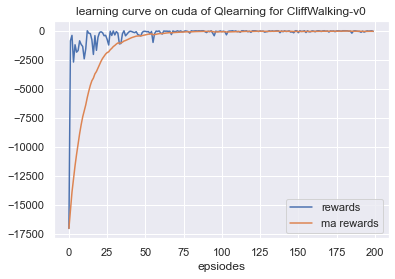

In [55]:
plot_rewards(rewards,ma_rewards, cfg)

Episode:10/50: Reward:-9
Episode:20/50: Reward:-33
Episode:30/50: Reward:-8
Episode:40/50: Reward:-31
Episode:50/50: Reward:-24
Complete evaling！
结果保存完毕！


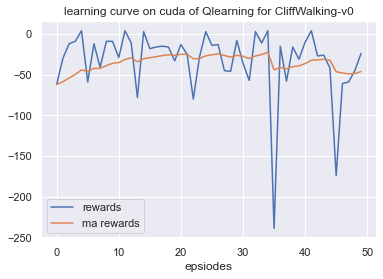

In [56]:
env,agent = env_agent_config(cfg,seed=10)
agent.load(path=cfg.model_path)
rewards,ma_rewards = eval(cfg,env,agent)
save_results(rewards,ma_rewards,tag='eval',path=cfg.result_path)
plot_rewards(rewards,ma_rewards,cfg, tag="eval")